In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid, cumulative_trapezoid
import pickle
from tqdm import tqdm, trange

from LIMxCMBL.experiments import *
import matplotlib.pyplot as plt 

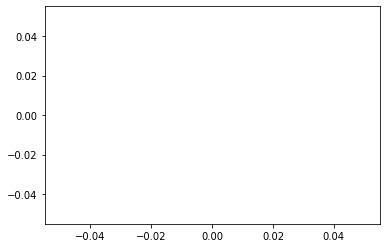

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1
})

In [3]:
e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#F9801D',
    'CCAT-prime':'#B02E26'
}

In [4]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
        'CCAT-prime',
           'SPHEREx',]

In [5]:
import matplotlib.patheffects as pe

In [6]:
from matplotlib.lines import Line2D


In [7]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2


In [31]:
Lambda_text = {
    0:r'\textsf{Unfiltered}',
    24: r'$\Lambda^{-1} = 10$ {\sf Mpc}',
    18: r'$\Lambda^{-1} = 100$ {\sf Mpc}'
}

/tmp/ipykernel_182018/3730106562.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad = 0.0)


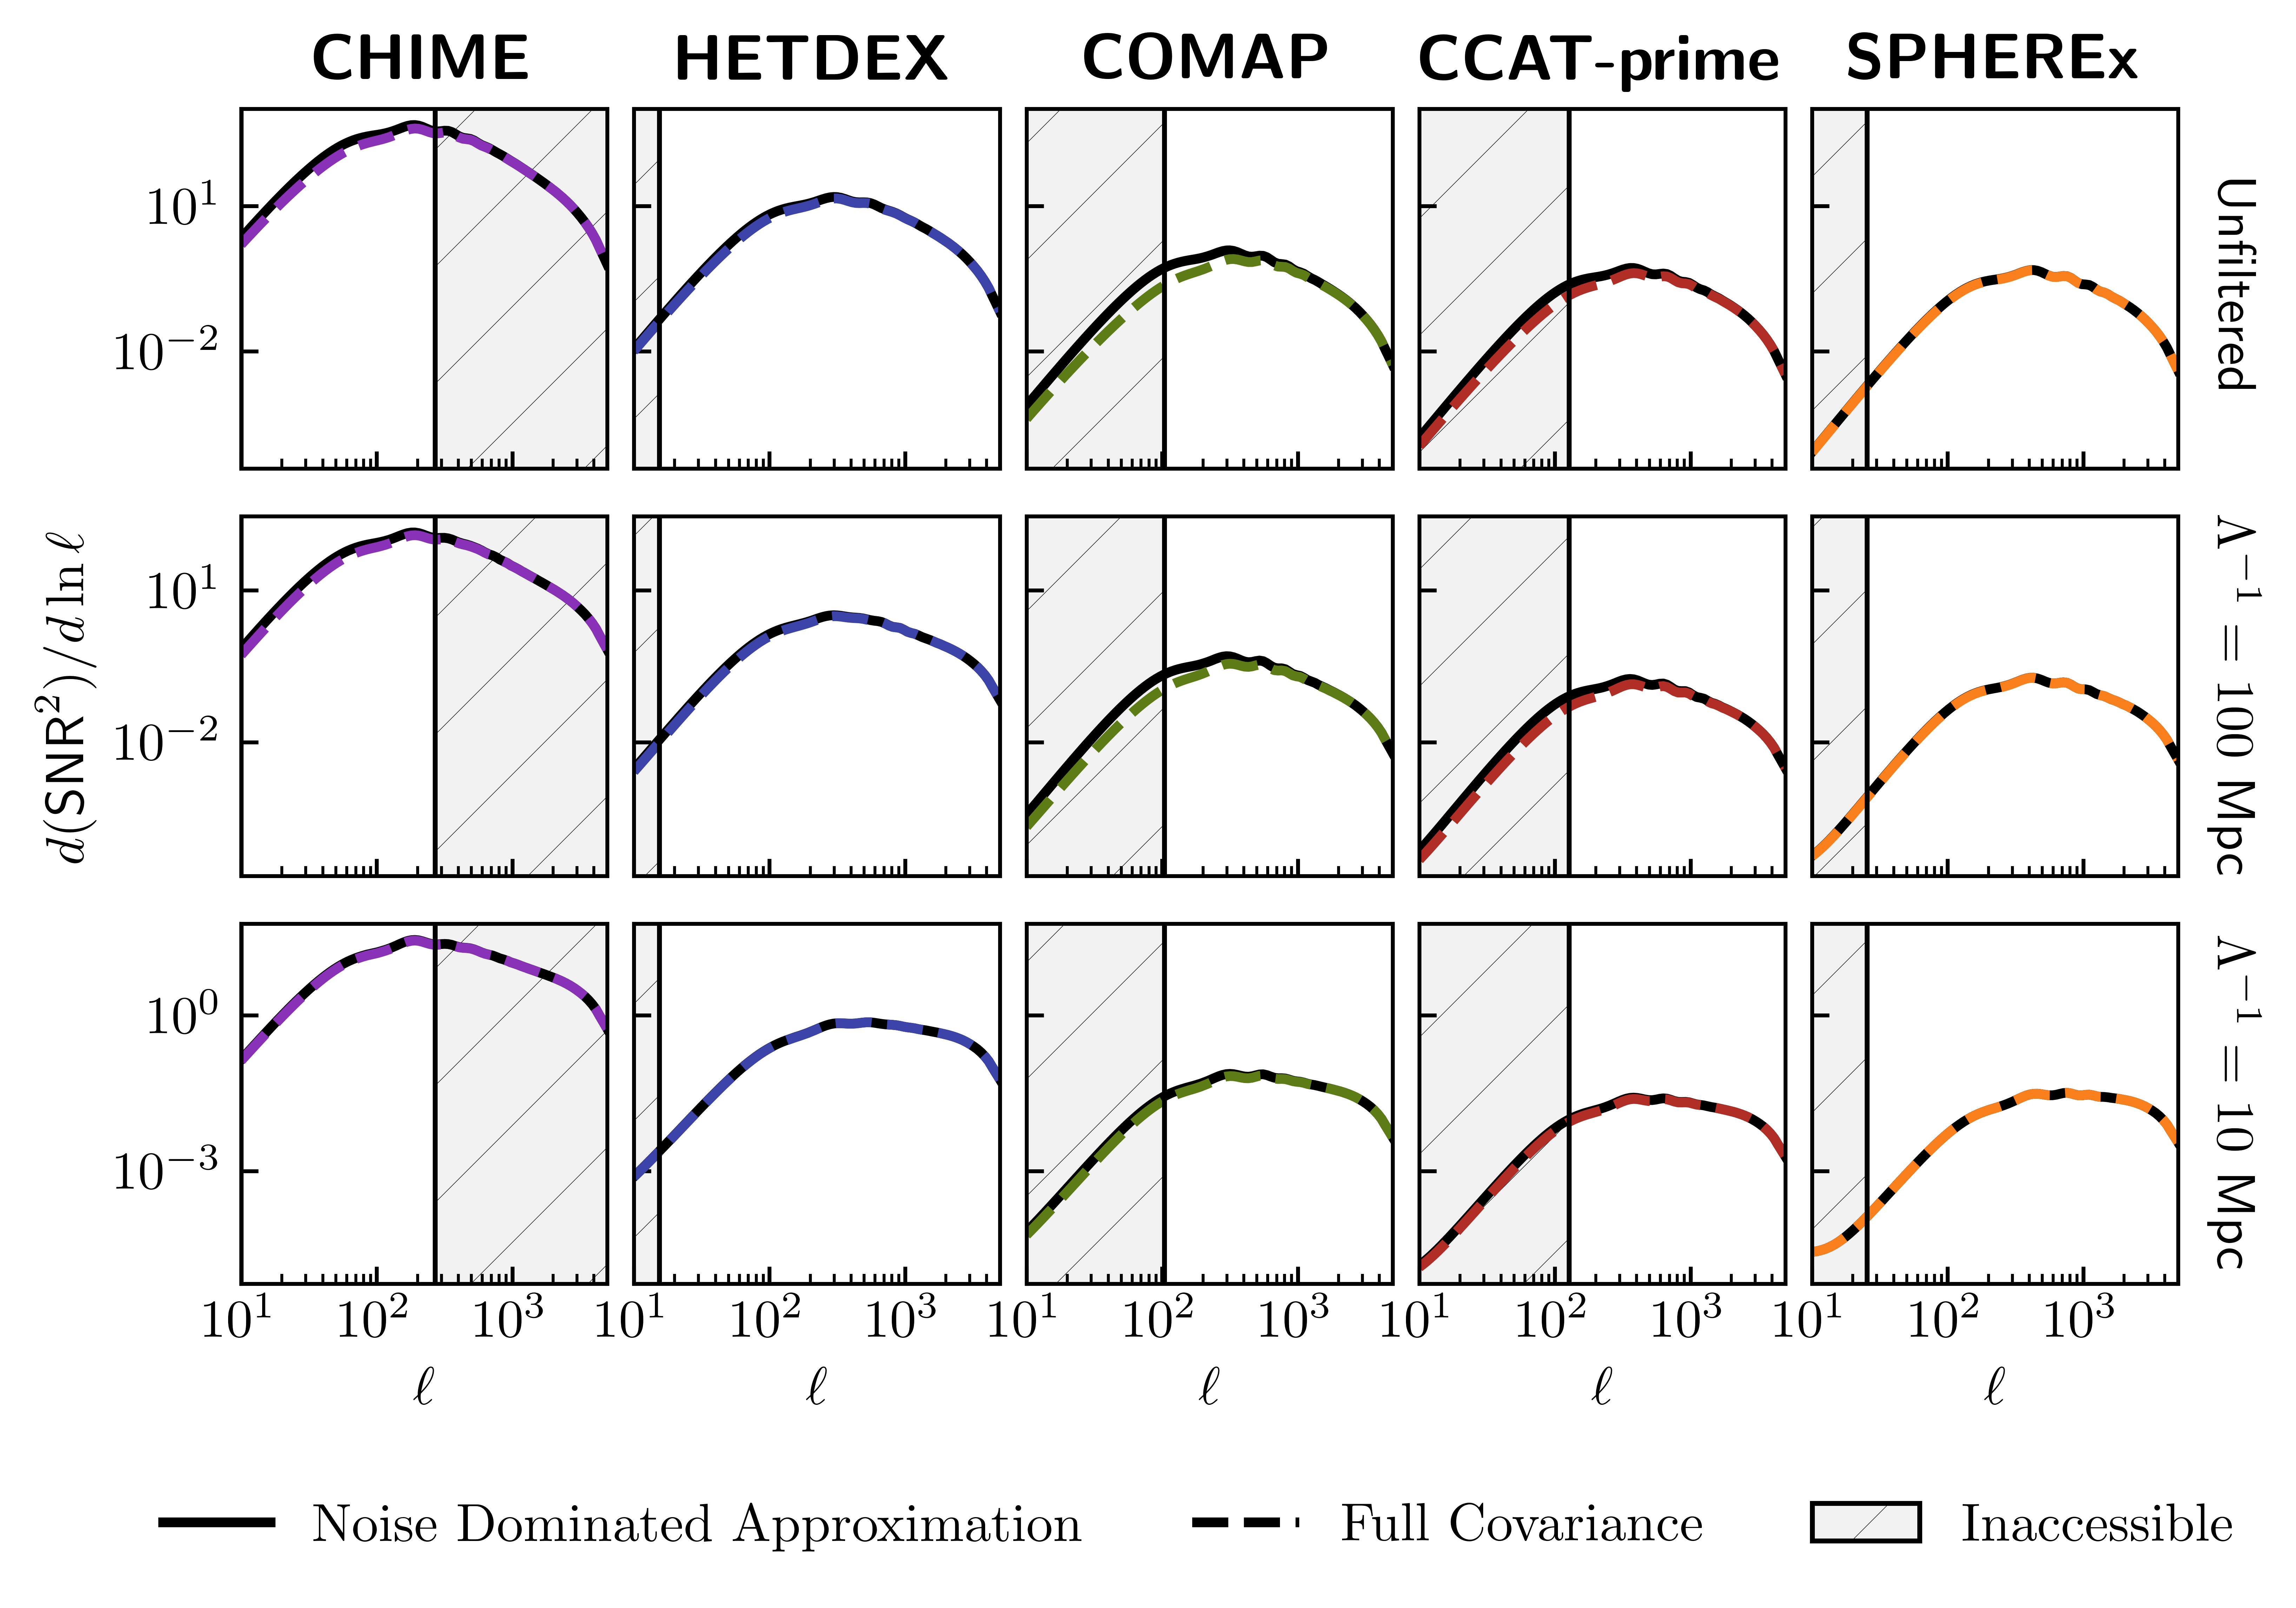

In [52]:
fig, meta_axs = plt.subplots(nrows=3, ncols=5, 
                             figsize = (5.8, 5.8/1.618), facecolor = 'w', dpi = 1000,
                             sharey='row',
                             sharex=True,
                            )
plt.tight_layout(pad = 0.0)

for e_idx, experiment in enumerate(e_order):
    
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']

    Omega_field  =  np.array(experiments[experiment]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)
    c = e_colors[experiment]

    for Lidx, Lambda_idx in enumerate([0, 18, 24]):
        ax = meta_axs[Lidx, e_idx]
        #metadata

        
        N0_fname = 'so'

        inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
        
        SNR2_per_mode_full = -1
        with open(inp_fname+experiment+'_full.pkl', 'rb') as f:
            SNR2_per_mode_full = pickle.load(f)
            
        SNR2_per_mode_noise_dom = -1
        with open(inp_fname+experiment+'_noise_dom.pkl', 'rb') as f:
            SNR2_per_mode_noise_dom = pickle.load(f)

        Lambda = Lambdas[Lambda_idx]
        _Lambdas = np.array(list(SNR2_per_mode_full.keys()))
        _Lambda = _Lambdas[np.argmin(np.abs(Lambda - _Lambdas))]
        if(Lambda_idx == 0):
            Lambda = 0.0

        full_dist = SNR2_per_mode_full[_Lambda] * ells ** 2 * Omega_field / 2 / np.pi
        noise_dom_dist = SNR2_per_mode_noise_dom[_Lambda] * ells ** 2 * Omega_field / 2 / np.pi

        
        ax.plot(ells,
                 noise_dom_dist,
             c='k',
                ls='-',
                lw=2,
                label='noise dom',
            )
        ax.plot(ells,
                 full_dist,
             c=c,
                ls='--',
                lw=2,
                label='full',
            )
    

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(10, 5000)
        ax.axvspan(0, ell_fundamental, alpha=1, facecolor="0.95", hatch='/',
                    rasterized=True, linewidth=0, edgecolor="k")

        ax.axvline(ell_fundamental, linewidth=1,color='k')

        ax.axvspan(ell_max_survey, 5000, alpha=1, facecolor="0.95", hatch='/',
                    rasterized=True, linewidth=0, edgecolor="k")

        ax.axvline(ell_max_survey, linewidth=1,color='k')


        if(e_idx == 0 and Lidx == 1):
            ax.set_ylabel('$d({\sf SNR}^2)/d \ln \ell$')
            
        if(e_idx == 4):
            ax.text(1.08, 0.5, Lambda_text[Lambda_idx], 
                     transform=ax.transAxes, 
                     ha='left', va='center',
                    rotation=-90)

        if(Lidx == 2):
            ax.set_xlabel(r'$\ell$')
        if(Lidx == 0):
            ax.set_title(r'\textsf{\textbf{%s}}'%(experiment))

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='k', lw=2, ls='-', label='Noise Dominated Approximation'),
    Line2D([0], [0], color='k', lw=2, ls='--', label=r'Full Covariance'),
    Patch(facecolor="0.95", hatch='/', edgecolor="k", lw=1, label=r'Inaccessible')
]

fig.legend(handles=legend_elements, 
           loc='lower center',
           bbox_to_anchor=(plt_cntr, -0.2),
           frameon=False,
           ncol=3)

plt.savefig('figures/013.008.pdf', bbox_inches='tight')